In [ ]:
import pandas as pd

# Import the fitnesses per position from ESM2_650M
wt_fitnesses = pd.read_csv("../Examples/wt_fitnesses_ESM2_650M.csv")
mut_fitnesses = pd.read_csv("../Examples/mut_fitnesses_ESM2_650M.csv")

# Import example indels for case study (see section ##)
GLMN = pd.read_csv("../Examples/GLMN_example.csv")
FGFR1 = pd.read_csv("../Examples/FGFR1_example.csv")

In [ ]:
# Extract sequences and indels IDs
GLMN_wtseq = GLMN['wt_seq'].values[0] #Wildtype sequence
GLMN_indels = GLMN['ID'].unique() #Indels IDs
GLMN_mutseq = {id_: GLMN.loc[GLMN['ID'] == id_, 'mut_seq'].values[0] for id_ in GLMN_indels} #Mutant sequences

FGFR1_wtseq = FGFR1['wt_seq'].values[0] #Wildtype sequence
FGFR1_indels = FGFR1['ID'].unique() #Indels IDs
FGFR1_mutseq = {id_: FGFR1.loc[FGFR1['ID'] == id_, 'mut_seq'].values[0] for id_ in FGFR1_indels} #Mutant sequences


In [5]:
from Bio.Align import PairwiseAligner
import pandas as pd
aligner = PairwiseAligner()
aligner.mode = 'global'

# Function to generate alinged sequences, adding gaps (-) to account to indels
def generate_aligned_strings(wt_seq, mut_seq, alignment):
    aligned_wt_str, aligned_mut_str = [], []
    last_idx1, last_idx2 = 0, 0

    for (start1, end1), (start2, end2) in zip(alignment.aligned[0], alignment.aligned[1]):
        aligned_wt_str.append(wt_seq[last_idx1:start1] + '-' * (start2 - last_idx2))
        aligned_mut_str.append('-' * (start1 - last_idx1) + mut_seq[last_idx2:start2])
        aligned_wt_str.append(wt_seq[start1:end1])
        aligned_mut_str.append(mut_seq[start2:end2])
        last_idx1, last_idx2 = end1, end2

    return ''.join(aligned_wt_str), ''.join(aligned_mut_str)

# Perform sequence alignment
def align_sequences(wt_seq, mut_seqs):
    aligned_results = {}
    for id_, mut_seq in mut_seqs.items():
        alignment = aligner.align(wt_seq, mut_seq)[0]  # Take the best alignment
        aligned_wt, aligned_mut = generate_aligned_strings(wt_seq, mut_seq, alignment)
        aligned_results[id_] = pd.DataFrame({
            f'{id_}wt': list(aligned_wt),
            f'{id_}mut': list(aligned_mut)
        })
    return aligned_results

# Process scores and align with sequences, skip when there is a gap (-)
def process_fitnesses(wt_fitnesses, mut_fitnesses, aligned_results, ids):
    result = {}
    for id_ in ids:
        wt_fitnesses_filtered = wt_fitnesses[wt_fitnesses['id'] == id_].drop(columns=['id'])
        mut_fitnesses_filtered = mut_fitnesses[mut_fitnesses['id'] == id_].drop(columns=['id'])
        
        # Flatten scores into lists
        wt_fitnesses_list = wt_fitnesses_filtered.values.flatten().tolist()
        mut_fitnesses_list = mut_fitnesses_filtered.values.flatten().tolist()

        # Align with sequence
        aligned_df = aligned_results[id_]

        # Create score rows, skipping gaps dynamically
        wt_iter = iter(wt_fitnesses_list)
        mut_iter = iter(mut_fitnesses_list)

        wt_row = [
            next(wt_iter) if char != '-' else '-'
            for char in aligned_df[f'{id_}wt']
        ]
        mut_row = [
            next(mut_iter) if char != '-' else '-'
            for char in aligned_df[f'{id_}mut']
        ]

        # Add the score rows to the DataFrame
        aligned_df[f'{id_}wt_fitnesses'] = wt_row
        aligned_df[f'{id_}mut_fitnesses'] = mut_row

        result[id_] = aligned_df

    return result

# Calculate the differences in scores per amino acid
def calculate_differences(aligned_results, ids):
    differences = {}
    for id_ in ids:
        # Retrieve aligned rows for wt and mut scores
        wt_row = aligned_results[id_][f'{id_}wt_fitnesses']
        mut_row = aligned_results[id_][f'{id_}mut_fitnesses']

        # Calculate differences
        diff = []
        for wt, mut in zip(wt_row, mut_row):
            if wt == '-' or mut == '-':
                diff.append(None)
            else:
                diff.append(mut - wt)
        
        # Convert to pandas Series and store
        differences[id_] = pd.Series(diff, name=f'{id_}_diff')
    
    return differences


In [ ]:
#Aling sequences
aligned_GLMN = align_sequences(GLMN_wtseq, GLMN_mutseq) 
aligned_FGFR1 = align_sequences(FGFR1_wtseq, FGFR1_mutseq)

#Input fitnesses scores in alingment
aligned_GLMN_fitnesses = process_fitnesses(wt_fitnesses, mut_fitnesses, aligned_GLMN, GLMN_indels) 
aligned_FGFR1_fitnesses = process_fitnesses(wt_fitnesses, mut_fitnesses, aligned_FGFR1, FGFR1_indels)

#Calculate differences per amino acid
fitnesses_differences_GLMN = calculate_differences(aligned_GLMN_fitnesses, GLMN_indels)
fitnesses_differences_FGFR1 = calculate_differences(aligned_FGFR1_fitnesses, FGFR1_indels)

In [31]:
#Extract differences per indel for plotting
GLMN_1, GLMN_diff_1 = list(fitnesses_differences_GLMN.items())[0]
GLMN_2, GLMN_diff_2 = list(fitnesses_differences_GLMN.items())[1]

FGFR1_1, FGFR1_diff_1 = list(fitnesses_differences_FGFR1.items())[0]
FGFR1_2, FGFR1_diff_2 = list(fitnesses_differences_FGFR1.items())[1]
FGFR1_3, FGFR1_diff_3 = list(fitnesses_differences_FGFR1.items())[2]
FGFR1_4, FGFR1_diff_4 = list(fitnesses_differences_FGFR1.items())[3]

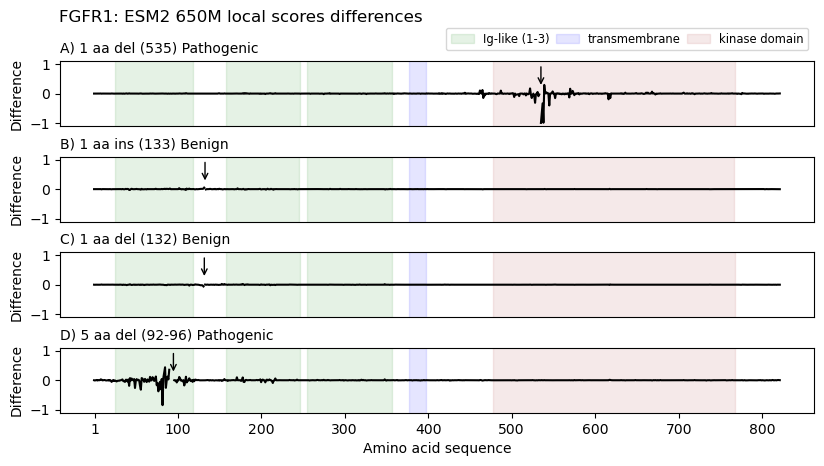

In [32]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(4,1)
f.set_figheight(4)
f.set_figwidth(8)
f.suptitle('FGFR1: ESM2 650M local scores differences', x=0.04, y=1.07, ha='left')
f.tight_layout(pad=0.1)
axes[0].plot(FGFR1_diff_1.index, FGFR1_diff_1.values, color = "black") 
axes[0].annotate('', xy=(535,0.2), xytext=(535,1), arrowprops=dict(arrowstyle='->', color = 'black'))
axes[0].axvspan(25,119, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1, label = 'Ig-like (1-3)')
axes[0].axvspan(158,246, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[0].axvspan(255,357, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[0].axvspan(377,397, ymin=-1.1, ymax=1.1, color='blue', alpha = 0.1, label = 'transmembrane')
axes[0].axvspan(478,767, ymin=-1.1, ymax=1.1, color='brown', alpha = 0.1, label = 'kinase domain')
axes[0].legend(fontsize = 'small', loc = 'upper right', bbox_to_anchor=(1, 1.6), ncol=len(axes[0].get_legend_handles_labels()[0]), columnspacing=0.5)
axes[0].set_title('A) 1 aa del (535) Pathogenic', loc = 'left', fontsize = 10)
axes[0].set(xticks=[])
axes[1].plot(FGFR1_diff_2.index, FGFR1_diff_2.values, color = "black")
axes[1].annotate('', xy=(133,0.2), xytext=(133,1), arrowprops=dict(arrowstyle='->', color = 'black'))
axes[1].axvspan(25,119, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[1].axvspan(158,246, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[1].axvspan(255,357, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[1].axvspan(377,397, ymin=-1.1, ymax=1.1, color='blue', alpha = 0.1)
axes[1].axvspan(478,767, ymin=-1.1, ymax=1.1, color='brown', alpha = 0.1)
axes[1].set_title('B) 1 aa ins (133) Benign', loc = 'left', fontsize = 10)
axes[1].set(xticks=[])
axes[2].plot(FGFR1_diff_3.index, FGFR1_diff_3.values, color = "black")
axes[2].annotate('', xy=(132,0.2), xytext=(132,1), arrowprops=dict(arrowstyle='->', color = 'black'))
axes[2].axvspan(25,119, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[2].axvspan(158,246, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[2].axvspan(255,357, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[2].axvspan(377,397, ymin=-1.1, ymax=1.1, color='blue', alpha = 0.1)
axes[2].axvspan(478,767, ymin=-1.1, ymax=1.1, color='brown', alpha = 0.1)
axes[2].set_title('C) 1 aa del (132) Benign', loc = 'left', fontsize = 10)
axes[2].set(xticks=[])
axes[3].plot(FGFR1_diff_4.index, FGFR1_diff_4.values, color = "black")
axes[3].annotate('', xy=(95,0.2), xytext=(95,1), arrowprops=dict(arrowstyle='->', color = 'black'))
axes[3].axvspan(25,119, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[3].axvspan(158,246, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[3].axvspan(255,357, ymin=-1.1, ymax=1.1, color='green', alpha = 0.1)
axes[3].axvspan(377,397, ymin=-1.1, ymax=1.1, color='blue', alpha = 0.1)
axes[3].axvspan(478,767, ymin=-1.1, ymax=1.1, color='brown', alpha = 0.1)
axes[3].set_title('D) 5 aa del (92-96) Pathogenic', loc = 'left', fontsize = 10)
axes[3].set(xticks = [1, 100, 200, 300, 400, 500, 600, 700, 800])
for ax in axes.flat:
    ax.set(xlabel = 'Amino acid sequence', ylabel ='Difference')
    ax.set(ylim = (-1.1,1.1))
for ax in axes.flat:
    ax.label_outer()
plt.savefig('FGFR1_diff.png', dpi=300, bbox_inches='tight')
plt.show()


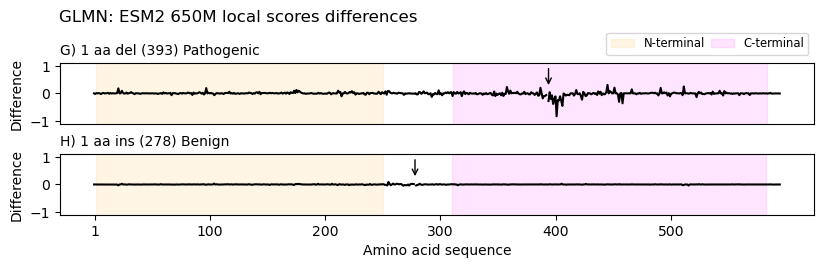

In [33]:
f, axes = plt.subplots(2,1)
f.set_figheight(2)
f.set_figwidth(8)
f.suptitle('GLMN: ESM2 650M local scores differences', x=0.04, y=1.15, ha='left')
f.tight_layout(pad=0.1)
axes[0].plot(GLMN_diff_1.index, GLMN_diff_1.values, color = "black")
axes[0].annotate('', xy=(393,0.2), xytext=(393,1), arrowprops=dict(arrowstyle='->', color = 'black'))
axes[0].axvspan(2,250, ymin=-1.1, ymax=1.1, color='orange', alpha = 0.1, label = 'N-terminal')
axes[0].axvspan(310,582, ymin=-1.1, ymax=1.1, color='magenta', alpha = 0.1, label = 'C-terminal')
axes[0].legend(fontsize = 'small', loc = 'upper right', bbox_to_anchor=(1, 1.6), ncol=len(axes[0].get_legend_handles_labels()[0]), columnspacing=0.5)
axes[0].set_title('G) 1 aa del (393) Pathogenic', loc = 'left', fontsize = 10)
axes[0].set(xticks=[])
axes[1].plot(GLMN_diff_2.index, GLMN_diff_2.values, color = "black")
axes[1].annotate('', xy=(278,0.2), xytext=(278,1), arrowprops=dict(arrowstyle='->', color = 'black'))
axes[1].axvspan(2,250, ymin=-1.1, ymax=1.1, color='orange', alpha = 0.1)
axes[1].axvspan(310,582, ymin=-1.1, ymax=1.1, color='magenta', alpha = 0.1)
axes[1].set_title('H) 1 aa ins (278) Benign', loc = 'left', fontsize = 10)
axes[1].set(xticks=[1, 100, 200, 300, 400, 500])
for ax in axes.flat:
    ax.set(xlabel = 'Amino acid sequence', ylabel ='Difference')
    ax.set(ylim = (-1.1,1.1))
for ax in axes.flat:
    ax.label_outer()
plt.savefig('GLMN_diff.png', dpi=300, bbox_inches='tight')
plt.show()
